# Alt-Test: How to Justify Replacing Humans by LLMs

To run the alt-test, you need two dictionaries: one with human annotations and another with LLM predictions. Then, you should call the `alt_test` function: <br>
```python
winning_rate, advantage_prob = alt_test(humans_annotations, llm_annotations, scoring_function, epsilon)
```

The `winning_rate` represents the proportion of humans the LLM "wins", and if `winning_rate >= 0.5` the LLM passes the test. <br>
The `advantage_prob` estimates the probability that the LLM annotations are as good as or better than a randomly selected human annotator. It should be used to compare LLMs (higher is better). <br>

### Parameters

- **`humans_annotations`**:
  A dictionary of dictionaries where:
  - Outer keys represent annotators (annotator ids).
  - Inner dictionaries with keys representing instances (instance ids) and values representing annotations.
  **Example:**
  ```python
  {
      'annotator1': {'instance1': 'A', 'instance2': 'B'},
      'annotator2': {'instance1': 'A', 'instance2': 'C', 'instance3': 'A'}
  }
  ```

- **`llm_annotations`**:
  A dictionary where the keys represent instances (instance ids) and the values represent LLM predictions.
  **Example:**
  ```python
  {'instance1': 'A', 'instance2': 'B', 'instance3': 'A'}
  ```

- **`scoring_function`**:
  Specifies how predictions are evaluated. Can be:
  - A string: `'accuracy'` or `'neg_rmse'`.
  - A custom function: Takes a prediction and a list of annotations as inputs, returning a score.

- **`epsilon`**:
  A float representing the cost-benefit penalty for the null hypothesis. Suggested values:
  - **0.2**: if annotators are experts.
  - **0.15**: if annotators are skilled.
  - **0.1**: if annotators are crowd-workers.

In [1]:
import json
import os
import numpy as np
from scipy.stats import ttest_1samp
from typing import Any, Optional, List, Tuple, Dict, Union, Callable

In [2]:
def open_json(file_path: str) -> Dict:
    with open(file_path, 'r') as f:
        return json.load(f)


def by_procedure(p_values: List[float], q: float) -> List[int]:
    p_values = np.array(p_values, dtype=float)
    m = len(p_values)
    sorted_indices = np.argsort(p_values)
    sorted_pvals = p_values[sorted_indices]
    # Compute the harmonic sum H_m = 1 + 1/2 + ... + 1/m
    H_m = np.sum(1.0 / np.arange(1, m + 1))
    # Compute the BY thresholds for each rank i
    by_thresholds = (np.arange(1, m + 1) / m) * (q / H_m)
    max_i = -1
    for i in range(m):
        if sorted_pvals[i] <= by_thresholds[i]:
            max_i = i
    if max_i == -1:
        return []
    rejected_sorted_indices = sorted_indices[:max_i + 1]
    return list(rejected_sorted_indices)


def accuracy(pred: Any, annotations: List[Any]) -> float:
    return float(np.mean([pred == ann for ann in annotations]))


def neg_rmse(pred: Union[int, float], annotations: List[Union[int, float]]) -> float:
    return -1 * float(np.sqrt(np.mean([(pred - ann) ** 2 for ann in annotations])))


def sim(pred: str, annotations: List[str], similarity_func: Callable) -> float:
    return float(np.mean([similarity_func(pred, ann) for ann in annotations]))


def ttest(indicators, epsilon: float) -> float:
    return ttest_1samp(indicators, epsilon, alternative='less').pvalue


def alt_test(llm_annotations: Dict[Union[int, str], Any],
             humans_annotations: Dict[Union[int, str], Dict[Union[int, str], Any]],
             scoring_function: Union[str, Callable] = 'accuracy',
             epsilon: float = 0.2,
             q_fdr: float = 0.05,
             min_humans_per_instance: int = 2,
             min_instances_per_human: int = 30):
    # prepare alignment scoring function
    if isinstance(scoring_function, str):
        if scoring_function == 'accuracy':
            scoring_function = accuracy
        elif scoring_function == 'neg_rmse':
            scoring_function = neg_rmse
        else:
            raise ValueError("Unknown scoring function")
    else:
        scoring_function = scoring_function

    # prepare sets - i_set has humans as keys, h_set has instances as keys
    i_set, h_set = {}, {}
    for h, anns in humans_annotations.items():
        i_set[h] = list(anns.keys())
        for i, ann in anns.items():
            if i not in h_set:
                h_set[i] = []
            h_set[i].append(h)

    # remove instances with less than min_humans_per_instance
    instances_to_keep = {i for i in h_set if len(h_set[i]) >= min_humans_per_instance and i in llm_annotations}
    if len(instances_to_keep) < len(h_set):
        print(f"Dropped {len(h_set) - len(instances_to_keep)} instances with less than {min_humans_per_instance} annotators.")
    i_set = {h: [i for i in i_set[h] if i in instances_to_keep] for h in i_set}
    h_set = {i: h_set[i] for i in h_set if i in instances_to_keep}

    p_values, advantage_probs, humans = [], [], []
    for excluded_h in humans_annotations:
        llm_indicators = []
        excluded_indicators = []
        instances = [i for i in i_set[excluded_h] if i in llm_annotations]
        if len(instances) < min_instances_per_human:
            print(f"Skipping annotator {excluded_h} with only {len(instances)} instances < {min_instances_per_human}.")
            continue

        for i in instances:
            human_ann = humans_annotations[excluded_h][i]
            llm_ann = llm_annotations[i]
            remaining_anns = [humans_annotations[h][i] for h in h_set[i] if h != excluded_h]
            human_score = scoring_function(human_ann, remaining_anns)
            llm_score = scoring_function(llm_ann, remaining_anns)
            llm_indicators.append(1 if llm_score >= human_score else 0)
            excluded_indicators.append(1 if human_score >= llm_score else 0)

        diff_indicators = [exc_ind - llm_ind for exc_ind, llm_ind in zip(excluded_indicators, llm_indicators)]
        p_values.append(ttest(diff_indicators, epsilon))
        advantage_probs.append(float(np.mean(llm_indicators)))
        humans.append(excluded_h)

    rejected_indices = by_procedure(p_values, q_fdr)
    advantage_prob = float(np.mean(advantage_probs))
    winning_rate = len(rejected_indices) / len(humans)
    return winning_rate, advantage_prob

### Example (paper's data)

In [3]:
annotations_folder = "data/"
datasets_scoring_functions = {
    'wax': 'accuracy',
    'lgbteen': 'accuracy',
    'mtbench': 'accuracy',
    'framing': 'accuracy',
    'cebab_aspects': 'accuracy',
    'summeval': 'neg_rmse',
    '10k_prompts': 'neg_rmse',
    'cebab_stars': 'neg_rmse',
    'lesion': 'neg_rmse',
}
datasets_epsilons = {
    'wax': 0.1,
    'lgbteen': 0.2,
    'mtbench': 0.2,
    'framing': 0.15,
    'cebab_aspects': 0.1,
    'summeval': 0.2,
    '10k_prompts': 0.15,
    'cebab_stars': 0.1,
    'lesion': 0.15,
}

for dataset_name, metric in datasets_scoring_functions.items():
    epsilon = datasets_epsilons[dataset_name]
    print(f"Computing {dataset_name}")
    humans_annotations = open_json(os.path.join(annotations_folder, dataset_name, 'human_annotations.json'))
    llms_annotations = open_json(os.path.join(annotations_folder, dataset_name, 'llm_annotations.json'))

    for llm_name, llm_annotations in llms_annotations.items():
        wr, ap = alt_test(llm_annotations, humans_annotations, metric, epsilon=epsilon)
        print(f"{dataset_name} {llm_name} [{'PASSED' if wr >= 0.5 else 'FAILED'}]:\tWinning Rate={wr:.2f}\tAdvantage Probability={ap:.2f}")
    print()

Computing wax
wax gemini_flash [FAILED]:	Winning Rate=0.38	Advantage Probability=0.69
wax gemini_pro [PASSED]:	Winning Rate=0.50	Advantage Probability=0.74
wax gpt-4o [PASSED]:	Winning Rate=0.50	Advantage Probability=0.73
wax llama-31 [FAILED]:	Winning Rate=0.00	Advantage Probability=0.57
wax gpt-4o-mini [FAILED]:	Winning Rate=0.00	Advantage Probability=0.59
wax mistral-v03 [FAILED]:	Winning Rate=0.00	Advantage Probability=0.50

Computing lgbteen
lgbteen gemini_flash [FAILED]:	Winning Rate=0.25	Advantage Probability=0.71
lgbteen gemini_pro [FAILED]:	Winning Rate=0.00	Advantage Probability=0.67
lgbteen gpt-4o [PASSED]:	Winning Rate=0.75	Advantage Probability=0.77
lgbteen llama-31 [FAILED]:	Winning Rate=0.00	Advantage Probability=0.72
lgbteen gpt-4o-mini [PASSED]:	Winning Rate=0.75	Advantage Probability=0.76
lgbteen mistral-v03 [FAILED]:	Winning Rate=0.25	Advantage Probability=0.75

Computing mtbench
mtbench gemini_flash [FAILED]:	Winning Rate=0.00	Advantage Probability=0.72
mtbench gemi

# 🧪 Simulation

The simulation setup here is based on Section C of the appendix in our paper.
Its purpose is to help you choose an appropriate value of \$\varepsilon\$ and determine the number of instances needed for a reliable alt-test.
You should adjust the parameters below to reflect the characteristics of your own annotation setup.

### 🔧 Parameters

| Parameter                    | Description                                                                                                               |
| ---------------------------- | ------------------------------------------------------------------------------------------------------------------------- |
| `n_datasets = 20`            | Number of independently generated datasets For each dataset, we sample a different priors vector. Used to reduce randomness and ensure robustness.                               |
| `n_boots = 10`               | Number of bootstrap samples taken per dataset for each instance size.                                                     |
| `sizes = [30, 40, ..., 200]` | List of instance sample sizes to simulate (in increments of 10). Helps evaluate test power as a function of dataset size. |
| `n_categories = 4`           | Number of annotation categories (i.e., class labels) in the task.                                                         |
| `max_items = 500`            | Total number of items in each simulated dataset.                                                                          |
| `max_annotators = 6`         | Total number of human annotators in each dataset.                                                                         |
| `n_annotators = 3`           | Number of annotators used in each bootstrap sample. This should be the number of annotators in your data.                                                                      |
| `noise_annotators = 0.3`     | Noise level for human annotators, controls the annotators reliability. See below.                                         |
| `noise_llm = 0.3`            | Noise level for the LLM annotations, controls the LLM reliability.                                                                                      |

> 💡 **Note:** You can adjust the `noise_annotators` parameter to reflect the reliability of your human annotators. Approximate mappings to inter-annotator agreement (Cohen’s \$\kappa\$) are:
>
> * 0.1 → IAA ≈ 0.80
> * 0.2 → IAA ≈ 0.63
> * 0.3 → IAA ≈ 0.48
> * 0.4 → IAA ≈ 0.36

In [4]:
from itertools import combinations
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

sns.set_style("whitegrid")
sns.axes_style({
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial',
     'DejaVu Sans',
     'Liberation Sans',
     'Bitstream Vera Sans',
     'sans-serif'],
     'xtick.bottom': False,
     'xtick.top': False,
     'ytick.left': False,
     'ytick.right': False,
     'axes.spines.left': True,
     'axes.spines.bottom': True,
     'axes.spines.right': True,
     'axes.spines.top': True
})


def sample_priors(n_categories):
    alpha = np.ones(n_categories)
    priors = np.random.dirichlet(alpha)
    return priors


def generate_dataset(priors, n_items, n_annotators, noise_annotators, noise_llm, seed=None):
    if seed is not None:
        np.random.seed(seed)

    n_categories = len(priors)
    dataset = {}

    for item_id in range(n_items):
        # Step 2: Sample gold label
        gold_label = np.random.choice(n_categories, p=priors)
        item = {'gold': int(gold_label)}

        # Step 3: Annotators
        for annotator in range(1, n_annotators + 1):
            probs = priors * noise_annotators
            probs[gold_label] += (1 - noise_annotators)
            probs = probs / probs.sum()  # Ensure sum to 1
            label = np.random.choice(n_categories, p=probs)
            item[f'annotator_{annotator}'] = int(label)

        # Step 4: LLM
        probs = priors * noise_llm
        probs[gold_label] += (1 - noise_llm)
        probs = probs / probs.sum()
        llm_label = np.random.choice(n_categories, p=probs)
        item['llm'] = int(llm_label)

        dataset[item_id] = item

    return dataset


def prepare_boot(dataset, n_items, n_annotators, replace=False):
    items = list(dataset.keys())
    items = list(np.random.choice(items, size=n_items, replace=replace))
    annotators = [k for k in dataset[items[0]] if k.startswith('annotator_')]
    annotators = list(np.random.choice(annotators, size=n_annotators, replace=replace)) + ['gold', 'llm']
    return {i: {a: dataset[i][a] for a in annotators} for i in items}


def split_dataset(dataset):
    first_row = next(iter(dataset.values()))
    annotator_keys = [k for k in first_row.keys() if k.startswith("annotator_")]
    llm_annotations = {}
    annotators_annotations = {ann: {} for ann in annotator_keys}
    for item_id, row in dataset.items():
        llm_annotations[item_id] = row["llm"]
        for ann in annotator_keys:
            annotators_annotations[ann][item_id] = row[ann]
    return llm_annotations, annotators_annotations


def compute_traditional_measures(dataset):
    """
    Args:
      dataset: dict mapping item_id -> {
         'gold': int,
         'annotator_1': int, …, 'annotator_k': int,
         'llm': int
      }
    Returns: dict with keys
      - agreements_anns: float
      - iaa_anns: float
      - agreements_llm: float
      - iaa_llm: float
      - accuracy_majority: float
      - f1_majority: float
    """
    # sort items
    item_ids = sorted(dataset.keys())
    n_items = len(item_ids)

    # detect annotator keys
    sample = dataset[item_ids[0]]
    ann_keys = sorted([k for k in sample if k.startswith("annotator_")],
                      key=lambda x: int(x.split("_")[1]))
    n_anns = len(ann_keys)

    # build arrays
    ann_labels = np.zeros((n_items, n_anns), dtype=int)
    llm_labels = np.zeros(n_items, dtype=int)
    for i, iid in enumerate(item_ids):
        row = dataset[iid]
        llm_labels[i] = row['llm']
        for j, k in enumerate(ann_keys):
            ann_labels[i, j] = row[k]

    # 1 & 2: annotator–annotator
    pair_agreements = []
    pair_kappas = []
    for i, j in combinations(range(n_anns), 2):
        a, b = ann_labels[:, i], ann_labels[:, j]
        pair_agreements.append((a == b).mean())
        pair_kappas.append(cohen_kappa_score(a, b))
    agreements_anns = np.mean(pair_agreements) if pair_agreements else np.nan
    iaa_anns = np.mean(pair_kappas) if pair_kappas else np.nan

    # 3 & 4: annotator–llm
    llm_agreements = []
    llm_kappas     = []
    for j in range(n_anns):
        a = ann_labels[:, j]
        llm_agreements.append((a == llm_labels).mean())
        llm_kappas.append(cohen_kappa_score(a, llm_labels))
    agreements_llm = np.mean(llm_agreements) if llm_agreements else np.nan
    iaa_llm = np.mean(llm_kappas) if llm_kappas else np.nan

    # 5 & 6: majority vote vs llm
    # infer number of categories
    all_labels = np.concatenate([ann_labels.ravel(), llm_labels])
    n_categories = all_labels.max() + 1

    majority = np.zeros(n_items, dtype=int)
    for i in range(n_items):
        counts = np.bincount(ann_labels[i], minlength=n_categories)
        majority[i] = counts.argmax()

    accuracy_majority = accuracy_score(llm_labels, majority)
    f1_majority = f1_score(llm_labels, majority, average='macro')

    return {
        'agreements_anns':    agreements_anns,
        'iaa_anns':           iaa_anns,
        'agreements_llm':  agreements_llm,
        'iaa_llm':         iaa_llm,
        'accuracy_majority':  accuracy_majority,
        'f1_majority':        f1_majority
    }


def results_to_df(results):
    records = []
    for n_categories, d0 in results.items():
        for noise_llm, d1 in d0.items():
            for noise_ann, d2 in d1.items():
                for size, metrics in d2.items():
                    row = {
                        'n_categories': n_categories,
                        'noise_llm': noise_llm,
                        'noise_ann': noise_ann,
                        'size': size,
                    }
                    row.update(metrics)
                    records.append(row)
    df = pd.DataFrame(records)
    return df

In [5]:
n_datasets = 20
n_boots = 10
sizes = list(range(30, 201, 10))  # 30 to 200 with step of 10
n_categories = 4
max_items = 500
max_annotators = 6
n_annotators = 3
noise_annotators = 0.3
noise_llm = 0.3
epsilons = [0.0, 0.05, 0.1, 0.2]


results = {size: {} for size in sizes}

for i_dataset in tqdm(range(n_datasets), desc=f'Simulation for K={n_categories}, η_h={noise_annotators}, η_f={noise_llm}'):
    priors = sample_priors(n_categories)
    dataset = generate_dataset(priors, max_items, max_annotators, noise_annotators, noise_llm)

    for size in sizes:
        for boot in range(n_boots):
            dataset_boot = prepare_boot(dataset, size, n_annotators, replace=False)
            llm_boot, annotators_boot = split_dataset(dataset_boot)

            metrics = compute_traditional_measures(dataset_boot)
            metrics['app'] = []
            winning_rates = {}
            for eps in epsilons:
                winning_rate, advantage_prob = alt_test(llm_boot, annotators_boot, 'accuracy', eps)
                metrics[f'wr_{eps}'] = winning_rate
                metrics['app'].append(advantage_prob)
            metrics['app'] = np.nanmean(metrics['app'])

            for k, v in metrics.items():
                if k not in results[size]:
                    results[size][k] = [v]
                else:
                    results[size][k].append(v)

for size in sizes:
    size_keys = list(results[size].keys())
    for k in size_keys:
        v_list = results[size][k]
        results[size][k] = float(np.nanmean(v_list))
        if k == 'app':
            results[size]['app_05'] = float(np.nanpercentile(v_list, 5))
            results[size]['app_95'] = float(np.nanpercentile(v_list, 95))

df = results_to_df({n_categories: {noise_llm: {noise_annotators: results}}})

Simulation for K=4, η_h=0.3, η_f=0.3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:40<00:00,  2.05s/it]


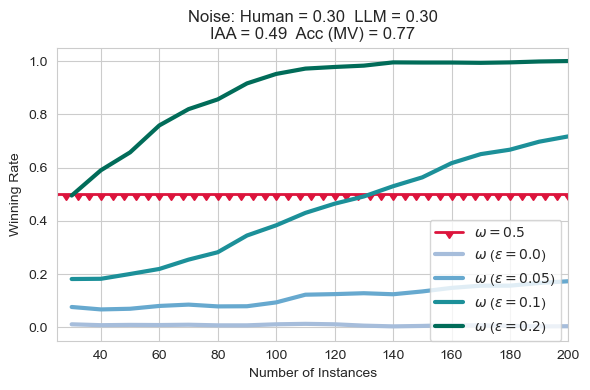

In [6]:
df = df.sort_values(by='size')
n_items = df['size'].to_numpy()

fig, ax = plt.subplots(figsize=(6, 4))
window = 3
wr_colors = ['#a6bddb', '#67a9cf', '#1c9099', '#016c59']


# Threshold line (w=0.5)
ax.plot(np.arange(0.0, 200.1, 4), [0.5 for _ in np.arange(0.0, 200.1, 4)], color='crimson',
            linestyle='-', marker=11, linewidth=2, label=r'$\omega=0.5$')

# Winning rate curves
for i, eps in enumerate(epsilons):
    wr = df[f'wr_{eps}'].rolling(window=window, min_periods=1).mean().to_numpy()
    ax.plot(n_items, wr, label=fr'$\omega$ ($\varepsilon = {eps}$)', color=wr_colors[i], linewidth=3)

# Annotation statistics
iaa_anns = df['iaa_anns'].mean()
accuracy_majority = df['accuracy_majority'].mean()

noise_ann_value, noise_llm_value = df['noise_ann'].mean(), df['noise_llm'].mean()
ax.set_title(f'Noise: Human = {noise_ann_value:.2f}  LLM = {noise_llm_value:.2f}\nIAA = {iaa_anns:.2f}  Acc (MV) = {accuracy_majority:.2f}')
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(25, 200)

ax.set_xlabel('Number of Instances')
ax.set_ylabel('Winning Rate')

ax.legend(loc='lower right', fontsize=10, frameon=True, bbox_to_anchor=(1, -0.025))
plt.tight_layout()
plt.show()